In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.utils.data.dataset import random_split
from torchvision.datasets import MNIST

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# train_dataset, val_dataset = random_split(train_dataset, [55000, 5000])
train_dataset = MNIST(root="../../data", download=True, transform=transforms.ToTensor(), train=True)
test_dataset = MNIST(root="../../data", transform=transforms.ToTensor(), train=False)


In [2]:
len(train_dataset)


60000

In [3]:
train_dataset, val_dataset = random_split(train_dataset, [55000, 5000])

In [4]:
train_loader = DataLoader(
  dataset=train_dataset,
  batch_size=64,
  shuffle=True,
  num_workers=11,
)

val_loader = DataLoader(
  dataset=val_dataset,
  batch_size=64,
  num_workers=11,
)

test_loader = DataLoader(
  dataset=test_dataset,
  batch_size=64,
  num_workers=11,
)

[(0, 5462), (1, 6229), (2, 5442), (3, 5628), (4, 5339), (5, 4929), (6, 5416), (7, 5770), (8, 5360), (9, 5425)]
[(0, 461), (1, 513), (2, 516), (3, 503), (4, 503), (5, 492), (6, 502), (7, 495), (8, 491), (9, 524)]
[(0, 980), (1, 1135), (2, 1032), (3, 1010), (4, 982), (5, 892), (6, 958), (7, 1028), (8, 974), (9, 1009)]


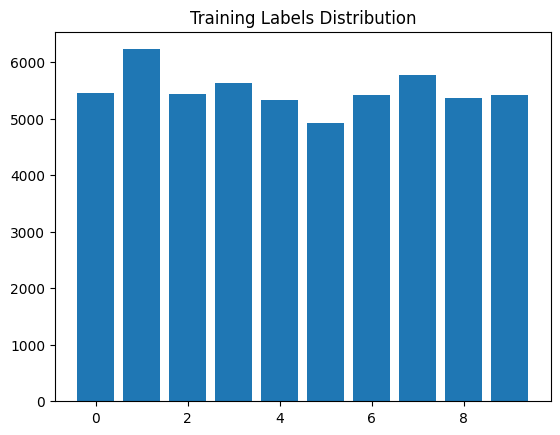

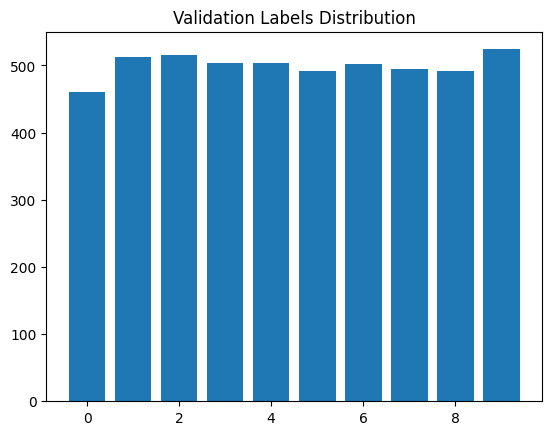

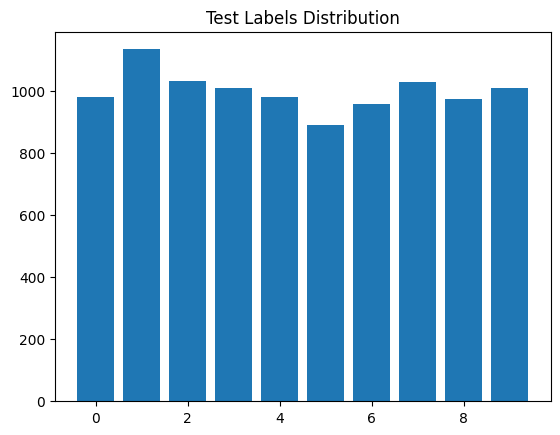

In [5]:
from collections import Counter

train_counter = Counter()
val_counter = Counter()
test_counter = Counter()

for images, true_labels in train_loader:
    train_counter.update(true_labels.tolist())
print(sorted(train_counter.items()))

for images, true_labels in val_loader:
    val_counter.update(true_labels.tolist())
print(sorted(val_counter.items()))

for images, true_labels in test_loader:
    test_counter.update(true_labels.tolist())
print(sorted(test_counter.items()))

# show histograms distributions
images, true_labels = next(iter(train_loader))
plt.bar(train_counter.keys(), train_counter.values())
plt.title("Training Labels Distribution")
plt.show()

images, true_labels = next(iter(val_loader))
plt.bar(val_counter.keys(), val_counter.values())
plt.title("Validation Labels Distribution")
plt.show()

images, true_labels = next(iter(test_loader))
plt.bar(test_counter.keys(), test_counter.values())
plt.title("Test Labels Distribution")
plt.show()



In [6]:
# Majority rule classifier

[majority_class, majority_amount] = test_counter.most_common(1)[0]
print('Majority class is', majority_class)
baseline_accuracy = majority_amount / sum(test_counter.values())
print('Accuracy when always predicting the majority class is', f"{baseline_accuracy*100:.2f}%")


Majority class is 1
Accuracy when always predicting the majority class is 11.35%


Grid shape: torch.Size([3, 242, 242])
Transposed grid shape: torch.Size([242, 242, 3])


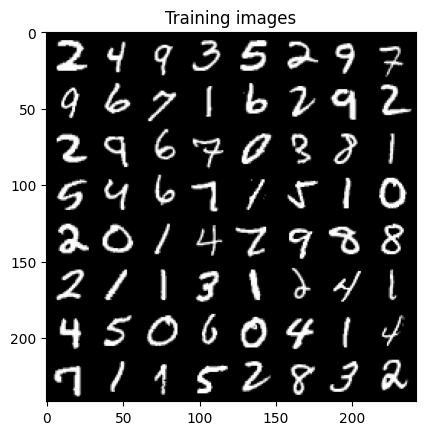

In [7]:
import numpy as np
import torchvision

images = next(iter(train_loader))[0]

grid = torchvision.utils.make_grid(
  images,
  padding=2,
  normalize=True,
)

print('Grid shape:', grid.shape)

grid = grid.transpose(0, 2)
grid = grid.transpose(0, 1)

print('Transposed grid shape:', grid.shape)

plt.imshow(grid)
plt.title('Training images')
plt.show()


In [8]:
from typing import Any
import lightning as L
import torchmetrics

class MnistClassifierModel(L.LightningModule):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
            nn.Flatten(),
            nn.Linear(9216, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10),
        )

        self.train_acc = torchmetrics.Accuracy(task='multiclass', num_classes=10).to(device)
        self.val_acc = torchmetrics.Accuracy(task='multiclass', num_classes=10).to(device)
        self.test_acc = torchmetrics.Accuracy(task='multiclass', num_classes=10).to(device)

    def forward(self, x):
        return self.model(x)
    
    def _shared_step(self, batch):
        features, true_labels = batch
        logits = self(features)
        loss = F.cross_entropy(logits, true_labels)
        predictions = torch.argmax(logits, dim=1)
        return loss, true_labels, predictions
    
    def training_step(self, batch, batch_idx: int):
        loss, true_labels, predictions = self._shared_step(batch)

        self.log('train_loss', loss)

        # Track accuracy
        self.train_acc(predictions, true_labels)
        self.log('train_acc', self.train_acc, prog_bar=True, on_epoch=True, on_step=False)

        return loss # this is passed to the optimizer for training
    
    def validation_step(self, batch, batch_idx: int):
        loss, true_labels, predictions = self._shared_step(batch)

        self.log('val_loss', loss, prog_bar=True)

        # Track accuracy
        self.val_acc(predictions, true_labels)
        self.log('val_acc', self.val_acc, prog_bar=True)

    def test_step(self, batch, batch_idx: int):
        loss, true_labels, predictions = self._shared_step(batch)

        # Track accuracy
        self.test_acc(predictions, true_labels)
        self.log('accuracy', self.test_acc, prog_bar=True)
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters())
        return optimizer


In [9]:
model = MnistClassifierModel().to(device)

trainer = L.Trainer(
  max_epochs=3,
  accelerator='gpu',
  devices='auto' # Use all available GPUs if applicable
)

trainer.fit(
  model,
  train_dataloaders=train_loader,
  val_dataloaders=val_loader
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | Sequential         | 1.2 M  | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.800     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


In [10]:

import torchmetrics

def compute_accuracy(model: nn.Module, loader: DataLoader):
    model.to(device)
    model = model.eval()

    # Manually compute accuracy
    # correct = 0.0
    # total = 0

    acc = torchmetrics.Accuracy(task='multiclass', num_classes=10).to(device)
    
    for idx, (features, labels) in enumerate(loader):
        features, labels = features.to(device), labels.to(device)
        with torch.no_grad():
            logits = model(features)
        predictions = torch.argmax(logits, dim=1)

        # Manually compute accuracy
        # compare = labels == predictions
        # correct += torch.sum(compare)
        # total += len(compare)

        acc(predictions, labels)
    return acc

# This is done in the model now with torchmetrics
def compute_accuracies():
    train_acc = compute_accuracy(model, train_loader).compute()
    val_acc = compute_accuracy(model, val_loader).compute()
    test_acc = compute_accuracy(model, test_loader).compute()

    print(f'Train accuracy: {train_acc * 100:.2f}%')
    print(f'Validation accuracy: {val_acc * 100:.2f}%')
    print(f'Test accuracy: {test_acc * 100:.2f}%')



train_acc = trainer.test(dataloaders=train_loader)[0]['accuracy']
val_acc = trainer.test(dataloaders=val_loader)[0]['accuracy']
test_acc = trainer.test(dataloaders=test_loader)[0]['accuracy']

print(f'Train accuracy: {train_acc * 100:.2f}%')
print(f'Validation accuracy: {val_acc * 100:.2f}%')
print(f'Test accuracy: {test_acc * 100:.2f}%')


/home/mat/.cache/pypoetry/virtualenvs/ml-pytorch-P31O4-yn-py3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /home/mat/ml-pytorch/mnist-model/lightning/lightning_logs/version_74/checkpoints/epoch=2-step=2580.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mat/ml-pytorch/mnist-model/lightning/lightning_logs/version_74/checkpoints/epoch=2-step=2580.ckpt
/home/mat/.cache/pypoetry/virtualenvs/ml-pytorch-P31O4-yn-py3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:475: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly rec

Testing: |          | 0/? [00:00<?, ?it/s]

Restoring states from the checkpoint path at /home/mat/ml-pytorch/mnist-model/lightning/lightning_logs/version_74/checkpoints/epoch=2-step=2580.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mat/ml-pytorch/mnist-model/lightning/lightning_logs/version_74/checkpoints/epoch=2-step=2580.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        accuracy            0.9912909269332886
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: |          | 0/? [00:00<?, ?it/s]

Restoring states from the checkpoint path at /home/mat/ml-pytorch/mnist-model/lightning/lightning_logs/version_74/checkpoints/epoch=2-step=2580.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mat/ml-pytorch/mnist-model/lightning/lightning_logs/version_74/checkpoints/epoch=2-step=2580.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        accuracy            0.9865999817848206
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        accuracy            0.9866999983787537
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Train accuracy: 99.13%
Validation accuracy: 98.66%
Test accuracy: 98.67%


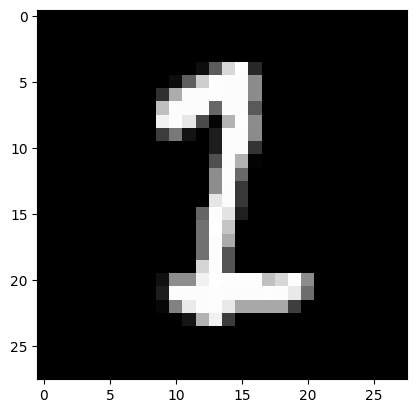

In [11]:
torch.manual_seed(0)

img = next(iter(train_loader))[0][10][0]

plt.imshow(img, cmap='gray')

In [12]:
model.eval()
trainer.test(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        accuracy            0.9866999983787537
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'accuracy': 0.9866999983787537}]